## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd

df = pd.read_csv("train.csv")

In [85]:
import matplotlib.pyplot as plt 


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

In [2]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

### Exploration

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

In [5]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
df[df.isnull().any(axis=1)]


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [7]:
df.dropna(inplace=True)

In [8]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [82]:
df_counts = df['is_duplicate'].value_counts()

In [83]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

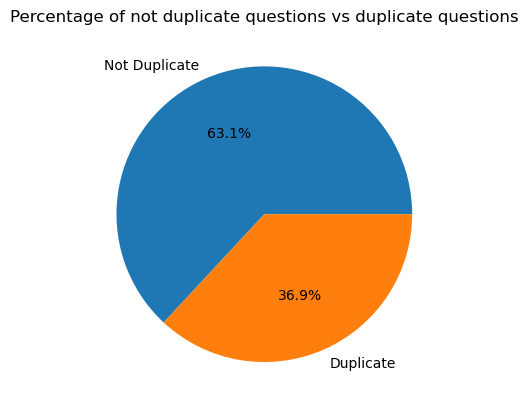

In [86]:
percentages = df_counts / len(df) * 100
percentages

# Plot as a pie chart
labels = ['Not Duplicate', 'Duplicate']
plt.pie(percentages, labels=labels, autopct='%1.1f%%') 
plt.title('Percentage of not duplicate questions vs duplicate questions')
plt.show()

In [87]:
# Select randomly a subset of non-duplicate questions to match the number of duplicate questions
duplicates = df[df['is_duplicate'] == 1] # Separate the duplicate and non-duplicate questions
non_duplicates = df[df['is_duplicate'] == 0]
num_duplicates = len(duplicates) # Get the number of duplicate questions
non_duplicates_sampled = non_duplicates.sample(num_duplicates) # Select a subset of non-duplicate questions

# Combine the sampled non-duplicate questions with the original duplicate questions
balanced_df = pd.concat([duplicates, non_duplicates_sampled], axis=0) 

# Shuffle the dataset to ensure that the duplicate and non-duplicate questions are mixed
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
balanced_df

,id,qid1,qid2,question1,question2,is_duplicate
0,122838,198734,198735,Why is Donald Trump a misogynist piece of donut?,Donald Trump: Does Donald Trump have misogynis...,0
1,29926,55322,55323,What is Brexit and what will be it's effect on...,How does Brexit affect India?,0
2,101176,167666,167667,What is usury?,Why is usury tolerated?,0
3,176053,270955,270956,Should I update to iOS 10 on my iPad Air 2?,How do I download WhatsApp on my iPad Air 2 iO...,0
4,288256,409186,409187,What is the salary after gate?,Are Google's salaries on Glassdoor after taxes?,0
...,...,...,...,...,...,...
298521,373828,71034,389432,How can someone submit a form without using th...,How can you submit a form without a submit but...,1
298522,334874,462098,462099,Which was the first ATM in Kerala?,Which is the first ATM introduced in Kerala?,1
298523,252312,36925,93650,How do I improve English writing skills as wel...,What are the best ways to improve my writing s...,1
298524,209592,222365,313922,"What is the best answer for ""Why do you want t...","What are the best answers ""Why you want to do ...",0


In [89]:
balanced_df['is_duplicate'].value_counts()

is_duplicate
0    149263
1    149263
Name: count, dtype: int64

In [121]:
balanced_df.shape


(298526, 6)

In [12]:
balanced_df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [106]:
df_test = balanced_df.groupby('is_duplicate', group_keys=False).apply(lambda x : x.sample(frac=0.3)).reset_index(drop=True)
df_train = balanced_df[~balanced_df.index.isin(df_test.index)].reset_index(drop=True)

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [107]:
# Import the necessary modules
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define the preprocess_all function
def preprocess_all(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation
    tokens = [token for token in tokens if token.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nasir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nasir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nasir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [108]:
# Apply preprocessing to 'question1' and 'question2' columns in X_train
df_train['question1_lemm'] = df_train['question1'].apply(preprocess_all)


In [109]:
df_train['question2_lemm'] = df_train['question2'].apply(preprocess_all)

In [120]:
df_train.shape

(208968, 8)

In [199]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_lemm,question2_lemm
0,211066,315809,315810,How do you transfer from a state school to a m...,How can I make a school management system usin...,0,"['transfer', 'state', 'school', 'competitive',...","['make', 'school', 'management', 'system', 'us..."
1,18391,34850,34851,I am constantly being compared to my cousin. S...,How can I make my girfriend trust that I'm tel...,0,"['constantly', 'compared', 'cousin', 'beautifu...","['make', 'girfriend', 'trust', 'telling', 'tru..."
2,88724,21861,149183,Are book collectors possessive about their boo...,If you could ask GRRM one question about GoT (...,0,"['book', 'collector', 'possessive', 'book', 'w...","['could', 'ask', 'grrm', 'one', 'question', 'g..."
3,166786,258715,258716,How do you spy on iPhone?,How do you spy on an iPhone 7?,1,"['spy', 'iphone']","['spy', 'iphone', '7']"
4,388903,521344,521345,What is Angle of Attack and how does it relate...,Aerodynamics: What is the role of Angle of Att...,1,"['angle', 'attack', 'relate', 'airplane', 'sta...","['aerodynamics', 'role', 'angle', 'attack', 'a..."


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [209]:
q1= [''.join(doc) for doc in df_train['question1_lemm']]
q2= [''.join(doc) for doc in df_train['question2_lemm']]

In [208]:
q1[3],q2[3]

("['spy', 'iphone']", "['spy', 'iphone', '7']")

In [215]:
questions = q1 + q2
questions[0]

"['transfer', 'state', 'school', 'competitive', 'school', 'majoring', 'accounting', 'management', 'information', 'system']"

In [259]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TF-IDF vectorizer and fit-transform on the corpus
vectorizer = TfidfVectorizer(max_features=50000, analyzer='word', use_idf=True, min_df=5, max_df=0.8)


In [260]:
vectorizer.fit(questions)

TfidfVectorizer(max_df=0.8, max_features=50000, min_df=5)

In [282]:
q1_vect = vectorizer.transform(q1)
q2_vect = vectorizer.transform(q2)

In [283]:
df_q1_vect = pd.DataFrame(q1_vect.toarray()).add_prefix('q1_')
df_q2_vect = pd.DataFrame(q2_vect.toarray()).add_prefix('q2_')


In [284]:
df_q1_vect.head()

,q1_0,q1_1,q1_2,q1_3,q1_4,q1_5,q1_6,q1_7,q1_8,q1_9,...,q1_4986,q1_4987,q1_4988,q1_4989,q1_4990,q1_4991,q1_4992,q1_4993,q1_4994,q1_4995
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [285]:
df_q2_vect.head()

,q2_0,q2_1,q2_2,q2_3,q2_4,q2_5,q2_6,q2_7,q2_8,q2_9,...,q2_4986,q2_4987,q2_4988,q2_4989,q2_4990,q2_4991,q2_4992,q2_4993,q2_4994,q2_4995
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [265]:
df_vect = pd.concat([df_q1_vect, df_q2_vect], axis=1)

In [286]:
df_vect.shape

(20000, 9992)

In [267]:
y = df_train['is_duplicate']

In [280]:
y.shape

(20000,)

In [269]:
feature_names = vectorizer.get_feature_names_out()


In [279]:
feature_names.shape

(4996,)

In [271]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_vect, y, test_size=0.2, random_state=15)

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [272]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
logR = LogisticRegression()


In [273]:
logR.fit(X_train, y_train)

LogisticRegression()

In [274]:
yhat = logR.predict(X_test)


In [275]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test, yhat)

0.66825

In [276]:
confusion_matrix(y_test, yhat)

array([[1318,  668],
       [ 659, 1355]], dtype=int64)

In [277]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_logR = accuracy_score(y_test, yhat)
precision_logR = precision_score(y_test, yhat)
recall_logR = recall_score(y_test, yhat)
f1_logR = f1_score(y_test, yhat)

print("Accuracy:", accuracy_logR)
print("Precision:", precision_logR)
print("Recall:", recall_logR)
print("F1-score:", f1_logR)

Accuracy: 0.66825
Precision: 0.6697973306969847
Recall: 0.6727904667328699
F1-score: 0.6712905622987366


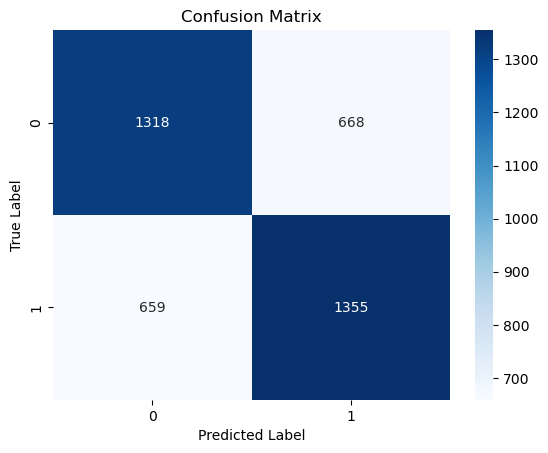

In [278]:
# Compute confusion matrix
cm_logR = confusion_matrix(y_test, yhat)

import seaborn as sns

# Plot confusion matrix using seaborn
sns.heatmap(cm_logR, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## XGBoost

In [132]:
from xgboost import XGBClassifier


In [133]:
xgbC = XGBClassifier(learning_rate=0.01)


In [134]:
xgbC.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [135]:
yhat_xg = xgbC.predict(X_test)


In [136]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy_score(y_test, yhat_xg)

0.6455

In [212]:
cm_xgbC =confusion_matrix(y_test, yhat_xg)

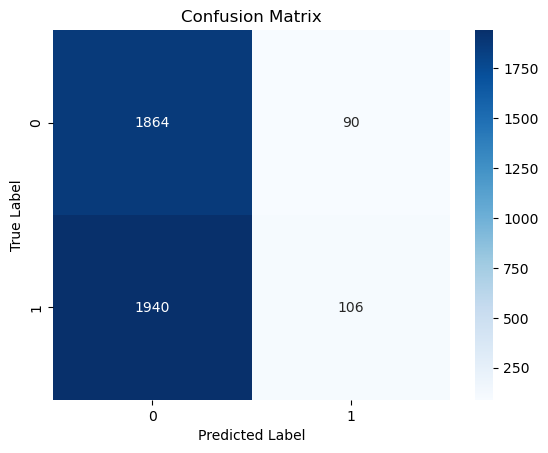

In [213]:


import seaborn as sns

# Plot confusion matrix using seaborn
sns.heatmap(cm_xgbC, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Gaussian

In [138]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()


In [140]:
gnb.fit(X_train.toarray(), y_train)


GaussianNB()

In [143]:
yhat_gnb = gnb.predict(X_test.toarray())
accuracy_score(y_test, yhat_gnb)

0.63925

In [144]:
confusion_matrix(y_test, yhat_gnb)

array([[1421, 1039],
       [ 404, 1136]], dtype=int64)

## Word2 Vec

In [145]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_lemm,question2_lemm
0,211066,315809,315810,How do you transfer from a state school to a m...,How can I make a school management system usin...,0,"['transfer', 'state', 'school', 'competitive',...","['make', 'school', 'management', 'system', 'us..."
1,18391,34850,34851,I am constantly being compared to my cousin. S...,How can I make my girfriend trust that I'm tel...,0,"['constantly', 'compared', 'cousin', 'beautifu...","['make', 'girfriend', 'trust', 'telling', 'tru..."
2,88724,21861,149183,Are book collectors possessive about their boo...,If you could ask GRRM one question about GoT (...,0,"['book', 'collector', 'possessive', 'book', 'w...","['could', 'ask', 'grrm', 'one', 'question', 'g..."
3,166786,258715,258716,How do you spy on iPhone?,How do you spy on an iPhone 7?,1,"['spy', 'iphone']","['spy', 'iphone', '7']"
4,388903,521344,521345,What is Angle of Attack and how does it relate...,Aerodynamics: What is the role of Angle of Att...,1,"['angle', 'attack', 'relate', 'airplane', 'sta...","['aerodynamics', 'role', 'angle', 'attack', 'a..."


In [146]:
# Convert the values in question1_lemm and question2_lemm to strings
df_train['question1_lemm'] = df_train['question1_lemm'].astype(str)
df_train['question2_lemm'] = df_train['question2_lemm'].astype(str)

In [118]:
df_train.dtypes

id                 int64
qid1               int64
qid2               int64
question1         object
question2         object
is_duplicate       int64
question1_lemm    object
question2_lemm    object
dtype: object

In [152]:
# Limit the number of rows
num_rows = 20000  # Choose the desired number of rows
df_train = df_train.head(num_rows)

In [153]:
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate,question1_lemm,question2_lemm
0,211066,315809,315810,How do you transfer from a state school to a m...,How can I make a school management system usin...,0,"['transfer', 'state', 'school', 'competitive',...","['make', 'school', 'management', 'system', 'us..."
1,18391,34850,34851,I am constantly being compared to my cousin. S...,How can I make my girfriend trust that I'm tel...,0,"['constantly', 'compared', 'cousin', 'beautifu...","['make', 'girfriend', 'trust', 'telling', 'tru..."
2,88724,21861,149183,Are book collectors possessive about their boo...,If you could ask GRRM one question about GoT (...,0,"['book', 'collector', 'possessive', 'book', 'w...","['could', 'ask', 'grrm', 'one', 'question', 'g..."
3,166786,258715,258716,How do you spy on iPhone?,How do you spy on an iPhone 7?,1,"['spy', 'iphone']","['spy', 'iphone', '7']"
4,388903,521344,521345,What is Angle of Attack and how does it relate...,Aerodynamics: What is the role of Angle of Att...,1,"['angle', 'attack', 'relate', 'airplane', 'sta...","['aerodynamics', 'role', 'angle', 'attack', 'a..."


In [154]:
df_train.shape

(20000, 8)

In [155]:
import pandas as pd
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [156]:
# Tokenize the preprocessed text for both questions
tokenized_question1 = df_train['question1_lemm'].apply(word_tokenize)
tokenized_question2 = df_train['question2_lemm'].apply(word_tokenize)

# Concatenate the tokenized questions
tokenized_text = tokenized_question1 + tokenized_question2



In [157]:
tokenized_text.shape

(20000,)

In [158]:

# Train the Word2Vec model
import gensim

# Load Google's pre-trained Word2Vec model.

model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=2, workers=4)

# Convert each document into a fixed-length vector representation
question1_vectors = []
for token_list in tokenized_question1:
    vectors = [model.wv[token] for token in token_list if token in model.wv]
    question1_vectors.append(vectors)

question2_vectors = []
for token_list in tokenized_question2:
    vectors = [model.wv[token] for token in token_list if token in model.wv]
    question2_vectors.append(vectors)


In [159]:
len(question1_vectors)

20000


### Modeling with Word2vec

In [165]:
import numpy as np

# Pad the question vectors to have the same length
max_length = max(len(q) for q in question1_vectors + question2_vectors)
padded_question1_vectors = [q + [np.zeros(100)] * (max_length - len(q)) for q in question1_vectors]
padded_question2_vectors = [q + [np.zeros(100)] * (max_length - len(q)) for q in question2_vectors]


# Combine the question vectors
document_vectors = [q1 + q2 for q1, q2 in zip(padded_question1_vectors, padded_question2_vectors)]


In [166]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(document_vectors, df_train['is_duplicate'], test_size=0.2, random_state=42)



In [167]:
# Convert X_train to a NumPy array
X_train_array = np.array(X_train)

# Flatten the X_train array
X_train_flattened = X_train_array.reshape(X_train_array.shape[0], -1)

# Initialize and train a logistic regression model
logregw = LogisticRegression()
logregw.fit(X_train_flattened, y_train)


C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [168]:
# Convert X_test to a NumPy array
X_test_array = np.array(X_test)

# Flatten the X_test array
X_test_flattened = X_test_array.reshape(X_test_array.shape[0], -1)

# Make predictions on the test set
y_predw = logregw.predict(X_test_flattened)

# Evaluate the model
accuracy = accuracy_score(y_test, y_predw)
print("Accuracy:", accuracy)

Accuracy: 0.6865


In [169]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Convert X_train to a NumPy array
X_train_array = np.array(X_train)

# Flatten the X_train array
X_train_flattened = X_train_array.reshape(X_train_array.shape[0], -1)


# Train the model
xgb_classifier.fit(X_train_flattened, y_train)


# Convert X_test to a NumPy array
X_test_array = np.array(X_test)

# Flatten the X_test array
X_test_flattened = X_test_array.reshape(X_test_array.shape[0], -1)

# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test_flattened)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7085


In [171]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.7085
Precision: 0.7186878727634195
Recall: 0.7067448680351907
F1-score: 0.7126663380975851


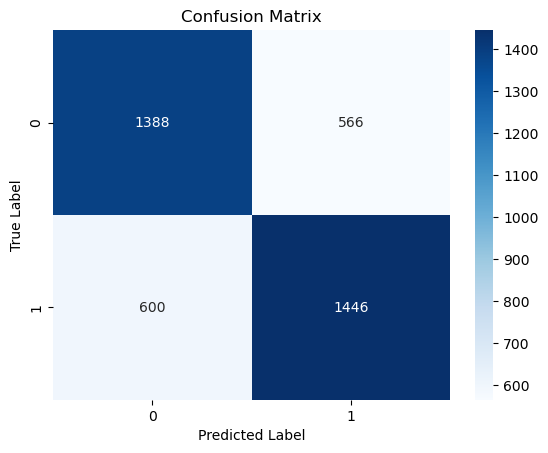

In [176]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns

# Plot confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [289]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Initialize the XGBoost classifier
xgb_classifier_gs = xgb.XGBClassifier()

# Define the hyperparameters grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300]
}

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_classifier_gs, param_grid=param_grid, cv=3)
grid_search.fit(X_train_flattened, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the model with the best parameters
best_xgb_classifier = xgb.XGBClassifier(**best_params)
best_xgb_classifier.fit(X_train_flattened, y_train)

# Make predictions on the test set
y_pred_xgb = best_xgb_classifier.predict(X_test_flattened)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)

ValueError: 
All the 81 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py", line 1471, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py", line 448, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py", line 908, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py", line 743, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py", line 962, in dispatch_data_backend
    return _from_numpy_array(data, missing, threads, feature_names, feature_types)
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\data.py", line 213, in _from_numpy_array
    _check_call(
  File "C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: bad allocation


In [290]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6895


In [291]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier
svm_classifier = SVC()

# Train the model
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6995


## Cosine Similarity as Feature

In [177]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Flatten the arrays
question1_vectors_flat = [vector for sublist in question1_vectors for vector in sublist]
question2_vectors_flat = [vector for sublist in question2_vectors for vector in sublist]



# Calculate cosine similarity between each pair of document vectors
cosine_similarities = [cosine_similarity([q1], [q2])[0][0] for q1, q2 in zip(question1_vectors_flat, question1_vectors_flat)]



In [178]:
# Convert cosine similarities to numpy array
cosine_similarities = np.array(cosine_similarities).reshape(-1, 1)

In [179]:
from sklearn.model_selection import train_test_split
cosine_similarities_subset = cosine_similarities[:len(df_train)]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cosine_similarities_subset, df_train['is_duplicate'], test_size=0.2, random_state=42)



In [182]:

import xgboost as xgb

# Initialize and train the XGBoost model
xgb_model_c = xgb.XGBClassifier()
xgb_model_c.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [183]:
# Make predictions on the test set
y_pred_c = xgb_model_c.predict(X_test)



Accuracy: 0.49825
Precision: 0.5135888501742161
Recall: 0.3602150537634409
F1-score: 0.42344153978741744


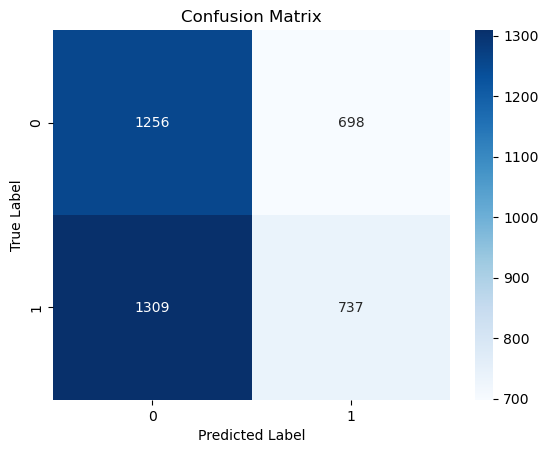

In [186]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_xgb_model_c = accuracy_score(y_test, y_pred_c)
precision_xgb_model_c = precision_score(y_test, y_pred_c)
recal_xgb_model_cl = recall_score(y_test, y_pred_c)
f1_xgb_model_c = f1_score(y_test, y_pred_c)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

from sklearn.metrics import confusion_matrix

cm_xgb_model_c = confusion_matrix(y_test, y_pred_c)

# Plot confusion matrix using seaborn
sns.heatmap(cm_xgb_model_c, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Logistic regress with cosine similarity

In [187]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix



# Create an instance of the logistic regression model
logreg = LogisticRegression()

# Fit the model on the training data
logreg.fit(X_train, y_train)

# Make predictions on the test data
y_logreg = logreg.predict(X_test)



Accuracy: 0.49825
Precision: 0.5135888501742161
Recall: 0.3602150537634409
F1-score: 0.42344153978741744


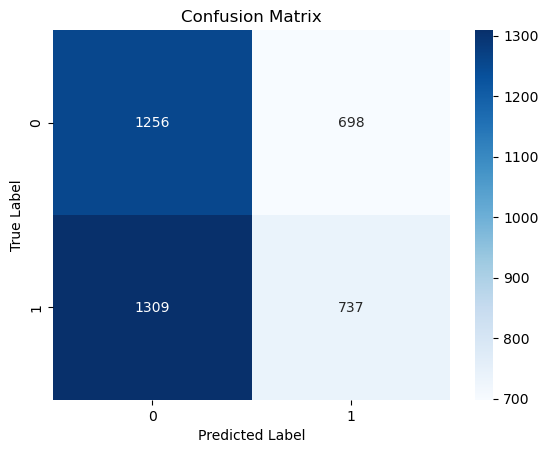

In [188]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_xgb_model_c = accuracy_score(y_test, y_logreg)
precision_xgb_model_c = precision_score(y_test, y_logreg)
recal_xgb_model_cl = recall_score(y_test, y_logreg)
f1_xgb_model_c = f1_score(y_test, y_logreg)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

from sklearn.metrics import confusion_matrix

cm_logreg = confusion_matrix(y_test, y_pred_c)

# Plot confusion matrix using seaborn
sns.heatmap(cm_logreg, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Union of Q1 and Q2

In [189]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Create a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer on the concatenated questions (q1 and q2) to build the vocabulary
questions = df_train['question1'] + ' ' + df_train['question2']
vectorizer.fit(questions)

# Transform the individual questions (q1 and q2) into feature vectors using the vectorizer
q1_vectors = vectorizer.transform(df_train['question1'])
q2_vectors = vectorizer.transform(df_train['question2'])



In [190]:
# Compute the union of q1 and q2 vectors as a feature using the element-wise maximum
union_vectors = q1_vectors.maximum(q2_vectors)



In [191]:
union_vectors

<20000x19969 sparse matrix of type '<class 'numpy.int64'>'
	with 294835 stored elements in Compressed Sparse Row format>

In [192]:

# Split the union vectors and target variable into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(union_vectors, df_train['is_duplicate'], test_size=0.2, random_state=42)

In [194]:

# Create an instance of the logistic regression model
logregu = LogisticRegression()

# Fit the model on the training data
logregu.fit(X_train, y_train)

# Make predictions on the test data
y_predu = logregu.predict(X_test)



C:\Users\nasir\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.49825
Precision: 0.5135888501742161
Recall: 0.3602150537634409
F1-score: 0.42344153978741744


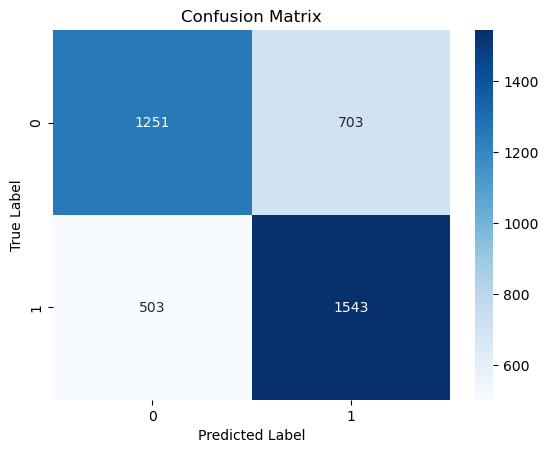

In [195]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_xgb_model_c = accuracy_score(y_test, y_predu)
precision_xgb_model_c = precision_score(y_test, y_predu)
recal_xgb_model_cl = recall_score(y_test, y_predu)
f1_xgb_model_c = f1_score(y_test, y_predu)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

from sklearn.metrics import confusion_matrix

cm_logregu = confusion_matrix(y_test, y_predu)

# Plot confusion matrix using seaborn
sns.heatmap(cm_logregu, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## xgboost

In [ ]:
import xgboost as xgb

# Create the XGBoost classifier
xgb_classifier_union = xgb.XGBClassifier()

xgb_classifier_union.fit(X_train, y_train)

y_pred_union = xgb_classifier_union.predict(X_test)

Accuracy: 0.49375
Precision: 0.5109717868338558
Recall: 0.23900293255131966
F1-score: 0.3256743256743257


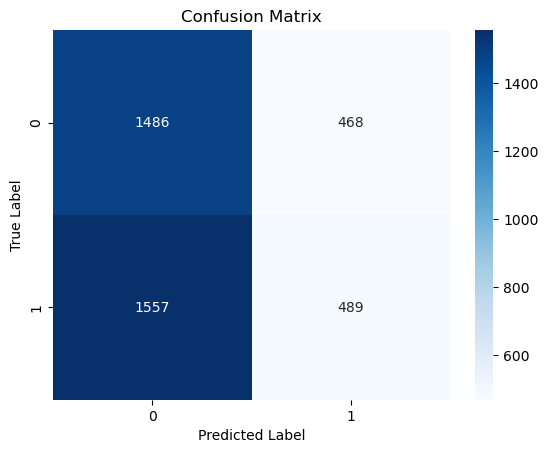

In [196]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_union)
precision = precision_score(y_test, y_pred_union)
recall = recall_score(y_test, y_pred_union)
f1 = f1_score(y_test, y_pred_union)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

from sklearn.metrics import confusion_matrix

cm_xgb_classifier_union = confusion_matrix(y_test, y_pred_union)

# Plot confusion matrix using seaborn
sns.heatmap(cm_xgb_classifier_union, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Grid search

In [197]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300]
}

# Create an XGBoost classifier
xgb_model_u = xgb.XGBClassifier()

# Perform grid search
grid_search = GridSearchCV(estimator=xgb_model_u, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Train the model with the best parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Make predictions
y_pred_grid = best_model.predict(X_test)

Accuracy: 0.688
Precision: 0.6855813953488372
Recall: 0.7204301075268817
F1-score: 0.7025738798856054


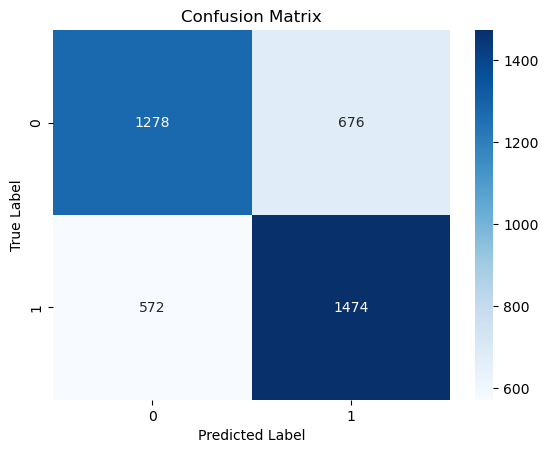

In [198]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_grid)
precision = precision_score(y_test, y_pred_grid)
recall = recall_score(y_test, y_pred_grid)
f1 = f1_score(y_test, y_pred_grid)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

from sklearn.metrics import confusion_matrix

cm_grid = confusion_matrix(y_test, y_pred_grid)

# Plot confusion matrix using seaborn
sns.heatmap(cm_grid, annot=True, cmap="Blues", fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()